In [5]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
import IPython.display as ipd
import random
import ast
import keras
import tensorflow as tf

from pandas.api.types import CategoricalDtype
from collections import Counter
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from pandas.api.types import CategoricalDtype
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from scipy.stats.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

<AxesSubplot:>

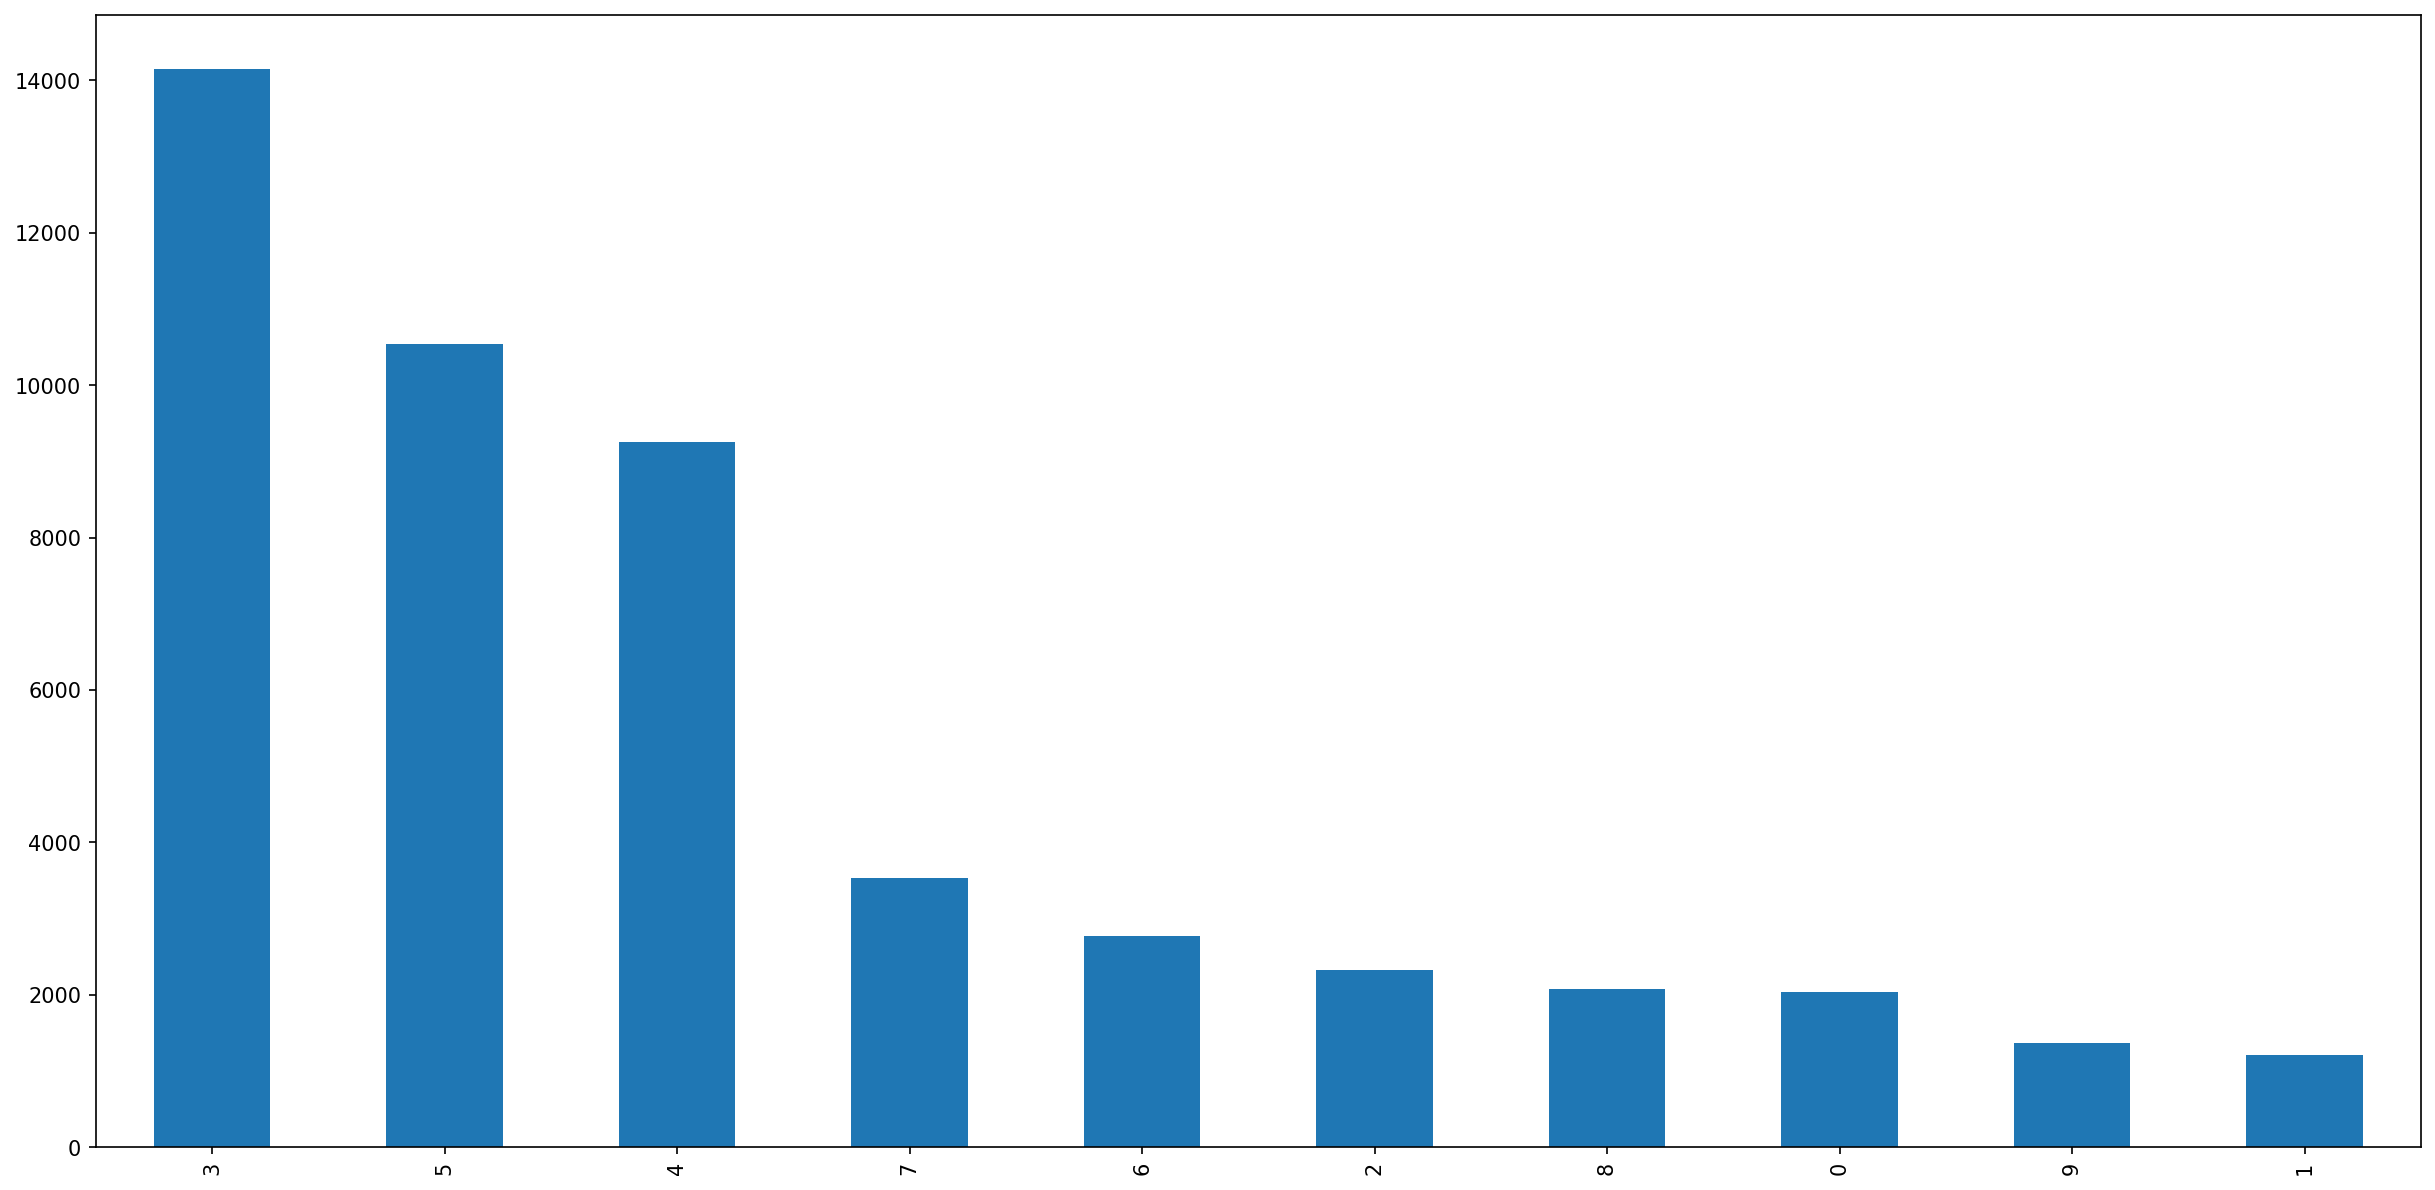

In [6]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2

df.TRACK_genre_top_num.value_counts().plot(kind='bar')

In [7]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_genre_top_num',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

# [OPZ] codice per creare le bitmap

In [8]:
bitmaps = {}
bitmaps[0] = pd.get_dummies(df["ALBUM_date_released_year_"].apply(pd.Series).stack()).sum(level=0)

bitmaps[1] = pd.get_dummies(df["ALBUM_tracks_"].apply(pd.Series).stack()).sum(level=0)

bitmaps[2] = pd.get_dummies(df["ALBUM_type_"].apply(pd.Series).stack()).sum(level=0)
bitmaps[3] = pd.get_dummies(df["TRACK_bitrate"].apply(pd.Series).stack()).sum(level=0)


for i in range(4):
    df = pd.concat([df, bitmaps[i]], axis=1)

    
df.drop(columns=["ALBUM_date_released_year_", 'ALBUM_tracks_', 'ALBUM_type_', 'TRACK_bitrate'], inplace=True)

df

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_number,rmsekurtosis01,rmsemax01,rmsemean01,rmsemedian01,rmsemin01,rmseskew01,rmsestd01,spectral_bandwidthkurtosis01,spectral_bandwidthmax01,spectral_bandwidthmean01,spectral_bandwidthmedian01,spectral_bandwidthmin01,spectral_bandwidthskew01,spectral_bandwidthstd01,spectral_centroidkurtosis01,spectral_centroidmax01,spectral_centroidmean01,spectral_centroidmedian01,spectral_centroidmin01,spectral_centroidskew01,spectral_centroidstd01,spectral_rolloffkurtosis01,spectral_rolloffmax01,spectral_rolloffmean01,spectral_rolloffmedian01,spectral_rolloffmin01,spectral_rolloffskew01,spectral_rolloffstd01,zcrkurtosis01,zcrmax01,zcrmean01,zcrmedian01,zcrmin01,zcrskew01,zcrstd01,TRACK_genres_soloTop,ARTIST_favorites_,ALBUM_listens_,ALBUM_favorites_,Blues,Classical,Country,Easy Listening,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Jazz,Old-Time / Historic,Pop,Rock,Soul-RnB,Spoken,chroma_censkurtosis,chroma_censmax,chroma_censmean,chroma_censmedian,chroma_censmin,chroma_censskew,chroma_censstd,chroma_censcqtkurtosis,chroma_cqtmax,chroma_cqtmean,chroma_cqtmedian,chroma_cqtmin,chroma_cqtskew,chroma_cqtstd,chroma_stftkurtosis,chroma_stftmax,chroma_stftmean,chroma_stftmedian,chroma_stftmin,chroma_stftskew,chroma_stftstd,mfcckurtosis,mfccmax,mfccmean,mfccmedian,mfccmin,mfccskew,mfccstd,spectral_contrastkurtosis,spectral_contrastmax,spectral_contrastmean,spectral_contrastmedian,spectral_contrastmin,spectral_contrastskew,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genre_top_num,1905.0,1907.0,1909.0,1911.0,1912.0,1913.0,1916.0,1930.0,1965.0,1967.0,1968.0,1969.0,1971.0,1973.0,1974.0,1976.0,1978.0,1979.0,1980.0,1981.0,1982.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2010.5,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2021.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,118.0,119.0,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0,136.0,137.0,138.0,139.0,140.0,141.0,142.0,143.0,144.0,145.0,146.0,147.0,148.0,149.0,150.0,151.0,152.0,153.0,154.0,155.0,156.0,157.0,158.0,159.0,160.0,161.0,162.0,163.0,164.0,165.0,166.0,168.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0,183.0,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,194.0,195.0,196.0,197.0,198.0,199.0,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,210.0,211.0,212.0,213.0,214.0,215.0,216.0,217.0,218.0,219.0,220.0,221.0,222.0,223.0,224.0,225.0,227.0,228.0,229.0,230.0,231.0,232.0,234.0,235.0,236.0,237.0,238.0,239.0,240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,248.0,249.0,255.0,0,2,3,4,24000,32000,40000,48000,56000,64000,80000,96000,112000,128000,144000,160000,192000,224000,256000,320000
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [9]:
#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0

# [OPZ] codice per reinserire tutte le features

### ATTENZIONE: non rimuove le features ottenute con la PCA

In [10]:
featuresdf = pd.read_csv('fma_metadata_progetto/features.csv', index_col=0, header=[0, 1, 2])

flat_features = pd.DataFrame()

for l1 in featuresdf.columns:
    name = ""
    for l2 in l1:
        name = name + l2
        
    flat_features[name] = featuresdf[l1]
    
df = pd.merge(df, flat_features, left_index=True, right_index=True)

df

ALBUM_date_released_year  ALBUM_favorites        ALBUM_type  \
track_id                                                                
2                           2009.0              4.0             Album   
3                           2009.0              4.0             Album   
5                           2009.0              4.0             Album   
10                          2008.0              4.0             Album   
134                         2009.0              4.0             Album   
...                            ...              ...               ...   
155315                      2017.0              0.0  Live Performance   
155316                      2017.0              0.0  Live Performance   
155317                      2017.0              0.0  Live Performance   
155318                      2017.0              0.0  Live Performance   
155319                      2017.0              0.0  Live Performance   

         ALBUM_tags  ALBUM_tracks  ALBUM_listens  \
track_id                                           
2                []           7.0         6073.0   
3                []           7.0         6073.0   
5                []           7.0         6073.0   
10               []           2.0        47632.0   
134              []           7.0         6073.0   
...             ...           ...            ...   
155315           []           6.0         1506.0   
155316           []           6.0         1506.0   
155317           []           6.0         1506.0   
155318           []           6.0         1506.0   
155319           []           6.0         1506.0   

                            ALBUM_title SET_subset  ARTIST_favorites  \
track_id                                                               
2                  AWOL - A Way Of Life      small          2.302585   
3                  AWOL - A Way Of Life     medium          2.302585   
5                  AWOL - A Way Of Life      small          2.302585   
10                    Constant Hitmaker      small          4.317488   
134                AWOL - A Way Of Life     medium          2.302585   
...                                 ...        ...               ...   
155315    Live at Monty Hall, 2/17/2017      large          0.000000   
155316    Live at Monty Hall, 2/17/2017      large          0.000000   
155317    Live at Monty Hall, 2/17/2017      large          0.000000   
155318    Live at Monty Hall, 2/17/2017      large          0.000000   
155319    Live at Monty Hall, 2/17/2017      large          0.000000   

         ARTIST_location              ARTIST_tags ARTIST_name  TRACK_duration  \
track_id                                                                        
2             New Jersey                 ['awol']        AWOL             168   
3             New Jersey                 ['awol']        AWOL             237   
5             New Jersey                 ['awol']        AWOL             206   
10                   NaN  ['philly', 'kurt vile']   Kurt Vile             161   
134           New Jersey                 ['awol']        AWOL             207   
...                  ...                      ...         ...             ...   
155315        New Jersey              ['spowder']     Spowder              38   
155316        New Jersey              ['spowder']     Spowder             162   
155317        New Jersey              ['spowder']     Spowder             217   
155318        New Jersey              ['spowder']     Spowder             404   
155319        New Jersey              ['spowder']     Spowder             146   

          TRACK_favorites TRACK_genre_top TRACK_genres_all TRACK_genres  \
track_id                                                                  
2                1.098612         Hip-Hop             [21]       ['21']   
3                0.693147         Hip-Hop             [21]       ['21']   
5                1.945910         Hip-Hop             [21]       ['21']   
10               

In [11]:
#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])


compl

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 32.0,
 33.0,
 35.0,
 31.0,
 34.0,
 38.0,
 39.0,
 40.0,
 36.0,
 37.0,
 43.0,
 44.0,
 'zcrmedian01_x',
 41.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 54.0,
 55.0,
 47.0,
 53.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 'spectral_centroidkurtosis01_x',
 91.0,
 92.0,
 93.0,
 94.0,
 90.0,
 'spectral_bandwidthskew01_x',
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 'rmsestd01_x',
 104.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 'spectral_bandwidthmedian01_x',
 125.0,
 127.0,
 128.0,
 126.0,
 12

# Sklearn Multilayer Perceptron

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [ ]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + features, [class_name]) #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

#Scalo i dati (ris no PCA, 1000, 500)
scaler = StandardScaler()    #0.6931610633836163
#scaler = MinMaxScaler()     #0.6896435094365149    ma ci mette una marea a convergere
#scaler = RobustScaler()     #0.6920110938239871

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
clf = MLPClassifier(random_state=0, hidden_layer_sizes=(1000, 500), learning_rate='adaptive', max_iter=1000, 
                    verbose=True, early_stopping=True)


#top 600, 300 6964080362578637         6895758641683014 (con tutte le bitmap)
#top 1000, 500 700872623959954         6974227152810661 <---
#top 2000, 1000 7085841845362917       7031725630792126
#top 4000, 2000 7109517689237638       6951227761618075

#----------3
# top 600 600 300 6950551308935939
# top 900 600 300 7058783738077522
# top 1200 800 400  7058783738077522

#---------4 
# top 1200 800 400 100 6990462017181898 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# Keras Deep Neural Networks

In [78]:
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [81]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl, [class_name]) #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = X_train
y_res = y_train

#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

#rus = RandomUnderSampler(random_state=42)
#X_val, y_val = rus.fit_resample(X_val, y_val)



scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler.fit(X_res)
X_res = scaler.transform(X_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



unique, counts = np.unique(y_train, return_counts=True)
print("train", dict(zip(unique, counts)))

unique, counts = np.unique(y_res, return_counts=True)
print("bilanciato", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("validation", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("test", dict(zip(unique, counts)))


#Trasformo la target value in vettore con 1 sulla posizione del genere giusto
y_res = tf.keras.utils.to_categorical(y_res, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

train {0: 1651, 1: 965, 2: 1902, 3: 11380, 4: 7528, 5: 8565, 6: 2232, 7: 2879, 8: 1692, 9: 1118}
bilanciato {0: 1651, 1: 965, 2: 1902, 3: 11380, 4: 7528, 5: 8565, 6: 2232, 7: 2879, 8: 1692, 9: 1118}
validation {0: 181, 1: 126, 2: 190, 3: 1359, 4: 805, 5: 925, 6: 264, 7: 303, 8: 171, 9: 111}
test {0: 204, 1: 121, 2: 233, 3: 1416, 4: 926, 5: 1054, 6: 277, 7: 354, 8: 207, 9: 136}


In [82]:
# FUNZIONI PER COSTRUIRE LA NN
def costruisci(n_layer_crescenti=5, initialHiddenLayer=128, n_layer_decrescenti = 5, finalHiddenLayer=128):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    
    for n in range(1, n_layer_crescenti+1):
        model.add(Dense(initialHiddenLayer*(n), activation='relu'))
        print("creo layer crescente di dimensione ", initialHiddenLayer*(n))
    for n in range(n_layer_decrescenti , 0, -1): #CODICE DEI TEST: for n in range(n_layer_decrescenti, 0, -1):
        model.add(Dense(finalHiddenLayer*(n), activation='relu'))
        print("creo layer decrescente di dimensione ", finalHiddenLayer*(n))
        
    model.add(Dense(y_res.shape[1], activation=tf.nn.softmax))

    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
    model.compile(loss='categorical_crossentropy', 
                  metrics=['accuracy'],
                  optimizer='adam', #2
                  #optimizer='adamax' #2
                  #optimizer='nadam' #4
                  #optimizer='adadelta' #177

                 ) #<-- multilabel/multiclass
    
    return model

In [83]:
model = costruisci(n_layer_crescenti=1, 
                   initialHiddenLayer=1100,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=900)

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


history1 = model.fit(X_res, y_res, epochs=1000, 
                      #batch_size= 200,
                      #class_weight=class_weight,
                      validation_data=(X_val, y_val), callbacks=[es,mc]
                     ).history

creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  900
Epoch 1/1000
1248/1248 [==============================] - 12s 10ms/step - loss: 1.2359 - accuracy: 0.6067 - val_loss: 0.9731 - val_accuracy: 0.6843
Epoch 2/1000
1248/1248 [==============================] - 12s 9ms/step - loss: 0.8905 - accuracy: 0.7061 - val_loss: 0.9759 - val_accuracy: 0.6875
Epoch 3/1000
1248/1248 [==============================] - 12s 9ms/step - loss: 0.7678 - accuracy: 0.7426 - val_loss: 0.8985 - val_accuracy: 0.7193
Epoch 4/1000
1248/1248 [==============================] - 12s 10ms/step - loss: 0.6499 - accuracy: 0.7773 - val_loss: 0.8649 - val_accuracy: 0.7306
Epoch 5/1000
1248/1248 [==============================] - 12s 10ms/step - loss: 0.5476 - accuracy: 0.8084 - val_loss: 0.9392 - val_accuracy: 0.7254
Epoch 6/1000
1248/1248 [==============================] - 12s 10ms/step - loss: 0.4479 - accuracy: 0.8451 - val_loss: 0.9675 - val_accuracy: 0.7312
Epoch 7/1000
1248/1248 [=======

In [25]:
layer1 = range(800, 1200 +1, 100)
layer2 = range(100, 900 +1, 200)

result = {}

for a in tqdm(layer1):
    for b in tqdm(layer2):
        model = costruisci(n_layer_crescenti=1, 
                   initialHiddenLayer=a,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=b)
        
        es = EarlyStopping(monitor='val_loss', patience=30)
        mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


        history1 = model.fit(X_res, y_res, epochs=1000, 
                              #batch_size= 200,
                              #class_weight=class_weight,
                              validation_data=(X_val, y_val), callbacks=[es,mc]
                             ).history
        
        test_loss, test_acc = model.evaluate(X_val, y_val)
        
        result[str(a)+"-"+str(b)] = str(test_acc) + str( test_loss)
        
        print('%f-%f     VAL: Loss %f, Accuracy %f' % (a, b, test_loss, test_acc))

creo layer crescente di dimensione  800
creo layer decrescente di dimensione  100
Epoch 1/1000
971/971 [==============================] - 4s 4ms/step - loss: 1.2428 - accuracy: 0.6036 - val_loss: 0.9450 - val_accuracy: 0.6872
Epoch 2/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.8184 - accuracy: 0.7279 - val_loss: 0.9095 - val_accuracy: 0.7049
Epoch 3/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.6507 - accuracy: 0.7821 - val_loss: 0.8539 - val_accuracy: 0.7229
Epoch 4/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.5010 - accuracy: 0.8354 - val_loss: 0.8608 - val_accuracy: 0.7284
Epoch 5/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.3826 - accuracy: 0.8746 - val_loss: 0.9368 - val_accuracy: 0.7180
Epoch 6/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.2615 - accuracy: 0.9174 - val_loss: 0.9982 - val_accuracy: 0.7313
Epoch 7/1000
971/971 [==============================] 

creo layer crescente di dimensione  900
creo layer decrescente di dimensione  100
Epoch 1/1000
971/971 [==============================] - 4s 3ms/step - loss: 1.2623 - accuracy: 0.5886 - val_loss: 0.9574 - val_accuracy: 0.6800
Epoch 2/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.8258 - accuracy: 0.7255 - val_loss: 0.8874 - val_accuracy: 0.7081
Epoch 3/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.6670 - accuracy: 0.7793 - val_loss: 0.9033 - val_accuracy: 0.7081
Epoch 4/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.5130 - accuracy: 0.8301 - val_loss: 0.9046 - val_accuracy: 0.7171
Epoch 5/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.3903 - accuracy: 0.8725 - val_loss: 0.9238 - val_accuracy: 0.7249
Epoch 6/1000
971/971 [==============================] - 3s 3ms/step - loss: 0.2710 - accuracy: 0.9141 - val_loss: 0.9648 - val_accuracy: 0.7206
Epoch 7/1000
971/971 [==============================] 

creo layer crescente di dimensione  1000
creo layer decrescente di dimensione  100
Epoch 1/1000
971/971 [==============================] - 4s 4ms/step - loss: 1.2598 - accuracy: 0.5929 - val_loss: 0.9815 - val_accuracy: 0.6762
Epoch 2/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.8397 - accuracy: 0.7215 - val_loss: 0.9080 - val_accuracy: 0.7052
Epoch 3/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.6704 - accuracy: 0.7748 - val_loss: 0.9182 - val_accuracy: 0.6988
Epoch 4/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.5242 - accuracy: 0.8262 - val_loss: 0.8602 - val_accuracy: 0.7258
Epoch 5/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.3852 - accuracy: 0.8761 - val_loss: 0.8916 - val_accuracy: 0.7354
Epoch 6/1000
971/971 [==============================] - 4s 4ms/step - loss: 0.2675 - accuracy: 0.9155 - val_loss: 0.9787 - val_accuracy: 0.7275
Epoch 7/1000
971/971 [==============================]

creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  100
Epoch 1/1000
971/971 [==============================] - 4s 4ms/step - loss: 1.2630 - accuracy: 0.5965 - val_loss: 0.9558 - val_accuracy: 0.6858
Epoch 2/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.8159 - accuracy: 0.7282 - val_loss: 0.9009 - val_accuracy: 0.7081
Epoch 3/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.6557 - accuracy: 0.7774 - val_loss: 0.8738 - val_accuracy: 0.7183
Epoch 4/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.5125 - accuracy: 0.8278 - val_loss: 0.8859 - val_accuracy: 0.7232
Epoch 5/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.3765 - accuracy: 0.8773 - val_loss: 0.9706 - val_accuracy: 0.7177
Epoch 6/1000
971/971 [==============================] - 3s 4ms/step - loss: 0.2468 - accuracy: 0.9242 - val_loss: 1.0063 - val_accuracy: 0.7400
Epoch 7/1000
971/971 [==============================]

creo layer crescente di dimensione  1200
creo layer decrescente di dimensione  100
Epoch 1/1000
971/971 [==============================] - 5s 4ms/step - loss: 1.2520 - accuracy: 0.5976 - val_loss: 0.9754 - val_accuracy: 0.6670
Epoch 2/1000
971/971 [==============================] - 4s 5ms/step - loss: 0.8255 - accuracy: 0.7245 - val_loss: 0.9200 - val_accuracy: 0.6907
Epoch 3/1000
971/971 [==============================] - 4s 5ms/step - loss: 0.6722 - accuracy: 0.7732 - val_loss: 0.9090 - val_accuracy: 0.7145
Epoch 4/1000
971/971 [==============================] - 4s 5ms/step - loss: 0.5302 - accuracy: 0.8265 - val_loss: 0.9159 - val_accuracy: 0.7191
Epoch 5/1000
971/971 [==============================] - 4s 5ms/step - loss: 0.3877 - accuracy: 0.8721 - val_loss: 0.9421 - val_accuracy: 0.7293
Epoch 6/1000
971/971 [==============================] - 4s 5ms/step - loss: 0.2659 - accuracy: 0.9166 - val_loss: 0.9816 - val_accuracy: 0.7255
Epoch 7/1000
971/971 [==============================]

In [24]:
dict(sorted(result.items(), key=lambda item: item[1]))

{'600-700': '0.72347825765609742.5017874240875244',
 '1000-1500': '0.72927534580230712.529742479324341',
 '1400-1500': '0.73014491796493532.6586358547210693',
 '1000-1100': '0.73072463274002082.569922685623169',
 '600-1500': '0.73333334922790532.59808087348938',
 '1400-300': '0.73420292139053342.3669869899749756',
 '1800-1500': '0.73507249355316162.4516584873199463',
 '600-300': '0.73536229133605962.3033535480499268',
 '1800-700': '0.73768115043640142.554591655731201',
 '1400-700': '0.73855072259902952.496938943862915',
 '600-1100': '0.7391304373741152.511855125427246',
 '1800-1100': '0.74376809597015382.4175307750701904',
 '1400-1100': '0.74405795335769652.5276782512664795',
 '1000-700': '0.74579709768295292.368901491165161',
 '1800-300': '0.74608695507049562.3559935092926025',
 '1000-300': '0.74753624200820922.348510980606079'}

'800-1200': '0.6924637556076052.134887456893921',
 '1200-1400': '0.6924637556076052.2831122875213623',
 '1300-1100': '0.69333332777023322.321800947189331',
 '1200-1700': '0.6944927573204042.3965771198272705',
 '1200-1300': '0.69855070114135742.325577735900879',
 '1100-1500': '0.6999999880790712.2375428676605225'}

In [28]:
test_loss, test_acc = model.evaluate(X_val, y_val)

print('VAL: Loss %f, Accuracy %f' % (test_loss, test_acc))

test_loss, test_acc = model.evaluate(X_test, y_test)

print('TEST: Loss %f, Accuracy %f' % (test_loss, test_acc))

108/108 [==============================] - 0s 2ms/step - loss: 2.2387 - accuracy: 0.7342
VAL: Loss 2.238715, Accuracy 0.734203
462/462 [==============================] - 1s 2ms/step - loss: 2.3443 - accuracy: 0.7210
TEST: Loss 2.344280, Accuracy 0.721031


In [ ]:
# Per runnare il modello finchè non è trovato un modello migliore
accuracyDaSuperare = 0.0

while True:
    model = costruisciTop(n_layer_crescenti=4, 
                   initialHiddenLayer=80,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=300)


    history1 = model.fit(X_res, y_res, epochs=1000, 
                          #batch_size= 128,
                          #class_weight=class_weight,
                          validation_data=(X_val, y_val), callbacks=[es,mc]
                         ).history
    
    test_loss, test_acc = model.evaluate(X_val, y_val)
    
    if(test_acc > accuracyDaSuperare):
        break
    
    clear_output(wait=True)
    print("")

In [48]:
model.save("modello_top")

INFO:tensorflow:Assets written to: modello_top/assets


In [49]:
modello_salvato = keras.models.load_model('modello_top')

In [84]:
y_pred = model.predict(X_test)

y_pred_bool = np.argmax(y_pred, axis=1) #si deve usare argmax o predict_classes
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

              precision    recall  f1-score   support

           0       0.78      0.59      0.67       204
           1       0.87      0.82      0.84       121
           2       0.38      0.33      0.35       233
           3       0.78      0.85      0.81      1416
           4       0.69      0.72      0.70       926
           5       0.75      0.74      0.75      1054
           6       0.65      0.67      0.66       277
           7       0.78      0.70      0.74       354
           8       0.61      0.56      0.58       207
           9       0.76      0.71      0.74       136

    accuracy                           0.73      4928
   macro avg       0.71      0.67      0.68      4928
weighted avg       0.73      0.73      0.73      4928



In [50]:
#classi predette e istanze per classe

y_pred = model1.predict_classes(X_test)

unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

NameError: name 'model1' is not defined

In [51]:
y_pred = modello_salvato.predict(X_test)

y_pred_bool = np.argmax(y_pred, axis=1) #si deve usare argmax o predict_classes
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       611
           1       0.91      0.80      0.85       364
           2       0.45      0.28      0.34       697
           3       0.81      0.82      0.82      4247
           4       0.66      0.74      0.70      2778
           5       0.72      0.72      0.72      3163
           6       0.64      0.66      0.65       832
           7       0.76      0.69      0.72      1061
           8       0.50      0.60      0.55       621
           9       0.68      0.66      0.67       409

    accuracy                           0.72     14783
   macro avg       0.68      0.66      0.67     14783
weighted avg       0.71      0.72      0.71     14783



In [ ]:
#Funzione per svuotare la VRAM nel caso non vengo fatto in automatico
K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()

In [12]:
# FUNZIONI PER COSTRUIRE LA NN
def costruisci(n_layer_crescenti=5, initialHiddenLayer=128, n_layer_decrescenti = 5, finalHiddenLayer=128):
    model = Sequential()
    model.add(Dense(X_res.shape[1], input_dim=X_res.shape[1], activation='relu'))
    
    for n in range(1, n_layer_crescenti+1):
        model.add(Dense(initialHiddenLayer*(n), activation='relu'))
        print("creo layer crescente di dimensione ", initialHiddenLayer*(n))
    for n in range(n_layer_decrescenti , 0, -1): #CODICE DEI TEST: for n in range(n_layer_decrescenti, 0, -1):
        model.add(Dense(finalHiddenLayer*(n), activation='relu'))
        print("creo layer decrescente di dimensione ", finalHiddenLayer*(n))
        
    model.add(Dense(y_res.shape[1], activation=tf.nn.softmax))

    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
    model.compile(loss='categorical_crossentropy', 
                  metrics=['accuracy'],
                  optimizer='adam', #2
                  #optimizer='adamax' #2
                  #optimizer='nadam' #4
                  #optimizer='adadelta' #177

                 ) #<-- multilabel/multiclass
    
    return model

In [21]:
percentuali = list(range(1, 101, 1))#[1, 5, 10, 20, 50, 70, 100]

def calcolaNRecord(length, percentage):
    return int((length*percentage)/100)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class_name = 'TRACK_genre_top_num'

attributes = Diff(compl, ['TRACK_genre_top_num'])
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler.fit(X_train)
X_test = scaler.transform(X_test)

y_test = tf.keras.utils.to_categorical(y_test, 10)

In [22]:
import time

accuracyRes = {}
f1Res = {}
timeRes = {}


for i in tqdm(percentuali):
    
    # PRENDO LE PERCENTUALI GIUSTE (e controllo che t_res e y_val ci siano tutte le target class)
    indices = np.random.choice(X_train.shape[0], calcolaNRecord(len(X_train), i), replace=False)
    
    X_train_sampled = X_train[indices]
    y_train_sampled = y_train.iloc[indices]
    
    X_res, X_val, y_res, y_val = train_test_split(X_train_sampled, y_train_sampled, test_size=0.1)
    
    while (len(np.unique(y_res)) != 10) | (len(np.unique(y_val)) != 10):
        indices = np.random.choice(X_train.shape[0], calcolaNRecord(len(X_train), i), replace=False)
        
        X_train_sampled = X_train[indices]
        y_train_sampled = y_train.iloc[indices]
        
        X_res, X_val, y_res, y_val = train_test_split(X_train_sampled, y_train_sampled, test_size=0.1)
        
    X_res = scaler.transform(X_res)
    X_val = scaler.transform(X_val)
    
    y_res = tf.keras.utils.to_categorical(y_res, 10)
    y_val = tf.keras.utils.to_categorical(y_val, 10)

    start_time = time.time()
    
    model = costruisci(n_layer_crescenti=1, 
                   initialHiddenLayer=1100,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=900)
        
    es = EarlyStopping(monitor='val_loss', patience=10)
    mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

    start_time = time.time()

    history1 = model.fit(X_res, y_res, epochs=1000, 
                          #batch_size= 200,
                          #class_weight=class_weight,
                          validation_data=(X_val, y_val), callbacks=[es,mc]
                         ).history
    
    timeRes[i] = time.time() - start_time
    
    y_pred = model.predict(X_test)

    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = np.argmax(y_test, axis=1)

    #print(classification_report(y_test_bool, y_pred_bool))
    
    accuracyRes[i] = accuracy_score(y_test_bool, y_pred_bool)
    f1Res[i] = f1_score(y_test_bool, y_pred_bool, average='weighted')

  0%|          | 0/100 [00:00<?, ?it/s]

creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  900
Epoch 1/1000
10/10 [==============================] - 0s 12ms/step - loss: 2.4220 - accuracy: 0.2471 - val_loss: 1.6585 - val_accuracy: 0.4571
Epoch 2/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.9724 - accuracy: 0.7161 - val_loss: 1.5992 - val_accuracy: 0.4000
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.4592 - accuracy: 0.8832 - val_loss: 1.9108 - val_accuracy: 0.4857
Epoch 4/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.1594 - accuracy: 0.9600 - val_loss: 2.1681 - val_accuracy: 0.6000
Epoch 5/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.0463 - accuracy: 0.9895 - val_loss: 2.4843 - val_accuracy: 0.4857
Epoch 6/1000
10/10 [==============================] - 0s 4ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 3.0858 - val_accuracy: 0.4286
Epoch 7/1000
10/10 [==============================] - 0s 5ms/ste

Epoch 6/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9441 - val_loss: 2.2937 - val_accuracy: 0.5652
Epoch 7/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.2351 - accuracy: 0.9283 - val_loss: 2.3031 - val_accuracy: 0.5710
Epoch 8/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.9216 - val_loss: 2.1867 - val_accuracy: 0.5855
Epoch 9/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.9646 - val_loss: 2.5338 - val_accuracy: 0.5797
Epoch 10/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9786 - val_loss: 2.8527 - val_accuracy: 0.5594
Epoch 11/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.0761 - accuracy: 0.9766 - val_loss: 2.9958 - val_accuracy: 0.5536
creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  900
Epoch 1/1000
107/107 [==============================] - 0s 2ms/

146/146 [==============================] - 0s 2ms/step - loss: 0.9315 - accuracy: 0.7024 - val_loss: 1.1180 - val_accuracy: 0.6564
Epoch 3/1000
146/146 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.7669 - val_loss: 1.2700 - val_accuracy: 0.6178
Epoch 4/1000
146/146 [==============================] - 0s 2ms/step - loss: 0.4987 - accuracy: 0.8394 - val_loss: 1.2777 - val_accuracy: 0.6139
Epoch 5/1000
146/146 [==============================] - 0s 2ms/step - loss: 0.3729 - accuracy: 0.8785 - val_loss: 1.3093 - val_accuracy: 0.6680
Epoch 6/1000
146/146 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9166 - val_loss: 1.4743 - val_accuracy: 0.6332
Epoch 7/1000
146/146 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9257 - val_loss: 1.9501 - val_accuracy: 0.6467
Epoch 8/1000
146/146 [==============================] - 0s 2ms/step - loss: 0.2373 - accuracy: 0.9274 - val_loss: 1.6980 - val_accuracy: 0.6313
Epoch

233/233 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8658 - val_loss: 1.5099 - val_accuracy: 0.6208
Epoch 6/1000
233/233 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.8871 - val_loss: 1.7233 - val_accuracy: 0.6546
Epoch 7/1000
233/233 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9235 - val_loss: 1.7549 - val_accuracy: 0.6377
Epoch 8/1000
233/233 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.9338 - val_loss: 1.9975 - val_accuracy: 0.6220
Epoch 9/1000
233/233 [==============================] - 0s 2ms/step - loss: 0.2016 - accuracy: 0.9405 - val_loss: 2.2599 - val_accuracy: 0.6304
Epoch 10/1000
233/233 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9517 - val_loss: 2.2516 - val_accuracy: 0.6365
Epoch 11/1000
233/233 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9758 - val_loss: 2.2608 - val_accuracy: 0.6401
Epo

321/321 [==============================] - 1s 2ms/step - loss: 0.2778 - accuracy: 0.9039 - val_loss: 1.6489 - val_accuracy: 0.6497
Epoch 8/1000
321/321 [==============================] - 1s 2ms/step - loss: 0.3357 - accuracy: 0.9068 - val_loss: 1.8547 - val_accuracy: 0.6330
Epoch 9/1000
321/321 [==============================] - 1s 2ms/step - loss: 0.1893 - accuracy: 0.9371 - val_loss: 2.1320 - val_accuracy: 0.6400
Epoch 10/1000
321/321 [==============================] - 1s 2ms/step - loss: 0.1680 - accuracy: 0.9477 - val_loss: 2.6634 - val_accuracy: 0.6348
Epoch 11/1000
321/321 [==============================] - 1s 2ms/step - loss: 0.1325 - accuracy: 0.9565 - val_loss: 2.3630 - val_accuracy: 0.6453
Epoch 12/1000
321/321 [==============================] - 1s 2ms/step - loss: 0.1968 - accuracy: 0.9496 - val_loss: 2.5440 - val_accuracy: 0.6286
creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  900
Epoch 1/1000
330/330 [==============================] - 1s 2ms/

369/369 [==============================] - 1s 2ms/step - loss: 1.4349 - accuracy: 0.5414 - val_loss: 1.0651 - val_accuracy: 0.6651
Epoch 2/1000
369/369 [==============================] - 1s 2ms/step - loss: 0.9233 - accuracy: 0.6945 - val_loss: 1.1068 - val_accuracy: 0.6445
Epoch 3/1000
369/369 [==============================] - 1s 2ms/step - loss: 0.7347 - accuracy: 0.7572 - val_loss: 1.1290 - val_accuracy: 0.6674
Epoch 4/1000
369/369 [==============================] - 1s 2ms/step - loss: 0.6133 - accuracy: 0.7888 - val_loss: 1.1272 - val_accuracy: 0.6728
Epoch 5/1000
369/369 [==============================] - 1s 2ms/step - loss: 0.4676 - accuracy: 0.8387 - val_loss: 1.2142 - val_accuracy: 0.6758
Epoch 6/1000
369/369 [==============================] - 1s 2ms/step - loss: 0.3613 - accuracy: 0.8720 - val_loss: 1.4121 - val_accuracy: 0.6751
Epoch 7/1000
369/369 [==============================] - 1s 2ms/step - loss: 0.2791 - accuracy: 0.9079 - val_loss: 1.4833 - val_accuracy: 0.6667
Epoch

447/447 [==============================] - 1s 2ms/step - loss: 0.1422 - accuracy: 0.9549 - val_loss: 2.3555 - val_accuracy: 0.6723
creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  900
Epoch 1/1000
456/456 [==============================] - 1s 3ms/step - loss: 1.4220 - accuracy: 0.5473 - val_loss: 1.1050 - val_accuracy: 0.6430
Epoch 2/1000
456/456 [==============================] - 1s 2ms/step - loss: 0.9067 - accuracy: 0.7070 - val_loss: 1.0553 - val_accuracy: 0.6634
Epoch 3/1000
456/456 [==============================] - 1s 2ms/step - loss: 0.7692 - accuracy: 0.7441 - val_loss: 1.0639 - val_accuracy: 0.6708
Epoch 4/1000
456/456 [==============================] - 1s 2ms/step - loss: 0.6225 - accuracy: 0.7844 - val_loss: 1.1784 - val_accuracy: 0.6665
Epoch 5/1000
456/456 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.8314 - val_loss: 1.3057 - val_accuracy: 0.6473
Epoch 6/1000
456/456 [==============================] - 1s 2ms/ste

495/495 [==============================] - 1s 2ms/step - loss: 0.4086 - accuracy: 0.8599 - val_loss: 1.6469 - val_accuracy: 0.6532
Epoch 7/1000
495/495 [==============================] - 1s 2ms/step - loss: 0.3159 - accuracy: 0.8864 - val_loss: 1.8992 - val_accuracy: 0.6657
Epoch 8/1000
495/495 [==============================] - 1s 2ms/step - loss: 0.2985 - accuracy: 0.8971 - val_loss: 1.6591 - val_accuracy: 0.6725
Epoch 9/1000
495/495 [==============================] - 1s 2ms/step - loss: 0.2244 - accuracy: 0.9275 - val_loss: 1.7332 - val_accuracy: 0.6748
Epoch 10/1000
495/495 [==============================] - 1s 2ms/step - loss: 0.1749 - accuracy: 0.9433 - val_loss: 2.0092 - val_accuracy: 0.6652
Epoch 11/1000
495/495 [==============================] - 1s 2ms/step - loss: 0.1496 - accuracy: 0.9502 - val_loss: 1.9831 - val_accuracy: 0.6725
Epoch 12/1000
495/495 [==============================] - 1s 2ms/step - loss: 0.1199 - accuracy: 0.9617 - val_loss: 2.3668 - val_accuracy: 0.6640
cr

Epoch 3/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.7659 - accuracy: 0.7411 - val_loss: 1.0177 - val_accuracy: 0.6865
Epoch 4/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.7845 - val_loss: 1.0388 - val_accuracy: 0.6884
Epoch 5/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.5108 - accuracy: 0.8218 - val_loss: 1.1357 - val_accuracy: 0.6807
Epoch 6/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.4640 - accuracy: 0.8372 - val_loss: 1.1964 - val_accuracy: 0.6826
Epoch 7/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8922 - val_loss: 1.3592 - val_accuracy: 0.6952
Epoch 8/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.3354 - accuracy: 0.8855 - val_loss: 1.5378 - val_accuracy: 0.6589
Epoch 9/1000
583/583 [==============================] - 1s 2ms/step - loss: 0.2170 - accuracy: 0.9244 - val_loss: 1.6340 - val_accuracy:

660/660 [==============================] - 1s 2ms/step - loss: 0.2122 - accuracy: 0.9249 - val_loss: 1.5743 - val_accuracy: 0.6790
Epoch 10/1000
660/660 [==============================] - 1s 2ms/step - loss: 0.2203 - accuracy: 0.9273 - val_loss: 1.5497 - val_accuracy: 0.6935
Epoch 11/1000
660/660 [==============================] - 1s 2ms/step - loss: 0.1711 - accuracy: 0.9451 - val_loss: 1.8884 - val_accuracy: 0.6816
Epoch 12/1000
660/660 [==============================] - 1s 2ms/step - loss: 0.1702 - accuracy: 0.9482 - val_loss: 1.7970 - val_accuracy: 0.6824
Epoch 13/1000
660/660 [==============================] - 1s 2ms/step - loss: 0.1508 - accuracy: 0.9563 - val_loss: 1.8934 - val_accuracy: 0.6944
creo layer crescente di dimensione  1100
creo layer decrescente di dimensione  900
Epoch 1/1000
670/670 [==============================] - 2s 2ms/step - loss: 1.3409 - accuracy: 0.5734 - val_loss: 1.0762 - val_accuracy: 0.6597
Epoch 2/1000
670/670 [==============================] - 1s 2ms

709/709 [==============================] - 2s 2ms/step - loss: 1.3156 - accuracy: 0.5797 - val_loss: 1.0124 - val_accuracy: 0.6696
Epoch 2/1000
709/709 [==============================] - 1s 2ms/step - loss: 0.8868 - accuracy: 0.7078 - val_loss: 0.9996 - val_accuracy: 0.6771
Epoch 3/1000
709/709 [==============================] - 1s 2ms/step - loss: 0.7634 - accuracy: 0.7420 - val_loss: 1.0089 - val_accuracy: 0.6747
Epoch 4/1000
709/709 [==============================] - 1s 2ms/step - loss: 0.6408 - accuracy: 0.7794 - val_loss: 1.0523 - val_accuracy: 0.6867
Epoch 5/1000
709/709 [==============================] - 1s 2ms/step - loss: 0.5285 - accuracy: 0.8180 - val_loss: 1.0880 - val_accuracy: 0.6767
Epoch 6/1000
709/709 [==============================] - 1s 2ms/step - loss: 0.4314 - accuracy: 0.8522 - val_loss: 1.2481 - val_accuracy: 0.6906
Epoch 7/1000
709/709 [==============================] - 1s 2ms/step - loss: 0.3500 - accuracy: 0.8755 - val_loss: 1.2775 - val_accuracy: 0.6910
Epoch

786/786 [==============================] - 2s 2ms/step - loss: 0.3609 - accuracy: 0.8754 - val_loss: 1.1809 - val_accuracy: 0.6854
Epoch 8/1000
786/786 [==============================] - 2s 2ms/step - loss: 0.2742 - accuracy: 0.9072 - val_loss: 1.3610 - val_accuracy: 0.6961
Epoch 9/1000
786/786 [==============================] - 2s 2ms/step - loss: 0.2427 - accuracy: 0.9195 - val_loss: 1.4573 - val_accuracy: 0.6908
Epoch 10/1000
786/786 [==============================] - 2s 2ms/step - loss: 0.2131 - accuracy: 0.9271 - val_loss: 1.6055 - val_accuracy: 0.6908
Epoch 11/1000
786/786 [==============================] - 2s 2ms/step - loss: 0.1961 - accuracy: 0.9377 - val_loss: 1.6817 - val_accuracy: 0.7011
Epoch 12/1000
786/786 [==============================] - 2s 2ms/step - loss: 0.1731 - accuracy: 0.9449 - val_loss: 2.1562 - val_accuracy: 0.6976
Epoch 13/1000
786/786 [==============================] - 2s 2ms/step - loss: 0.1980 - accuracy: 0.9449 - val_loss: 1.9204 - val_accuracy: 0.7019
c

Epoch 3/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.7761 - accuracy: 0.7376 - val_loss: 0.9793 - val_accuracy: 0.7018
Epoch 4/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.6509 - accuracy: 0.7823 - val_loss: 1.0359 - val_accuracy: 0.7034
Epoch 5/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.5375 - accuracy: 0.8148 - val_loss: 1.0427 - val_accuracy: 0.7050
Epoch 6/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.4449 - accuracy: 0.8454 - val_loss: 1.1458 - val_accuracy: 0.6957
Epoch 7/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.3523 - accuracy: 0.8782 - val_loss: 1.2560 - val_accuracy: 0.7105
Epoch 8/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.2968 - accuracy: 0.8996 - val_loss: 1.2493 - val_accuracy: 0.7014
Epoch 9/1000
874/874 [==============================] - 2s 2ms/step - loss: 0.2480 - accuracy: 0.9186 - val_loss: 1.4203 - val_accuracy:

951/951 [==============================] - 2s 2ms/step - loss: 0.6568 - accuracy: 0.7769 - val_loss: 0.9993 - val_accuracy: 0.7072
Epoch 5/1000
951/951 [==============================] - 2s 2ms/step - loss: 0.5540 - accuracy: 0.8078 - val_loss: 1.1299 - val_accuracy: 0.7116
Epoch 6/1000
951/951 [==============================] - 2s 2ms/step - loss: 0.4583 - accuracy: 0.8383 - val_loss: 1.1071 - val_accuracy: 0.7187
Epoch 7/1000
951/951 [==============================] - 2s 2ms/step - loss: 0.3592 - accuracy: 0.8764 - val_loss: 1.2524 - val_accuracy: 0.7093
Epoch 8/1000
951/951 [==============================] - 2s 2ms/step - loss: 0.3009 - accuracy: 0.8937 - val_loss: 1.3497 - val_accuracy: 0.7161
Epoch 9/1000
951/951 [==============================] - 2s 2ms/step - loss: 0.2579 - accuracy: 0.9106 - val_loss: 1.5421 - val_accuracy: 0.7187
Epoch 10/1000
951/951 [==============================] - 2s 2ms/step - loss: 0.2108 - accuracy: 0.9292 - val_loss: 1.6736 - val_accuracy: 0.7113
Epoc

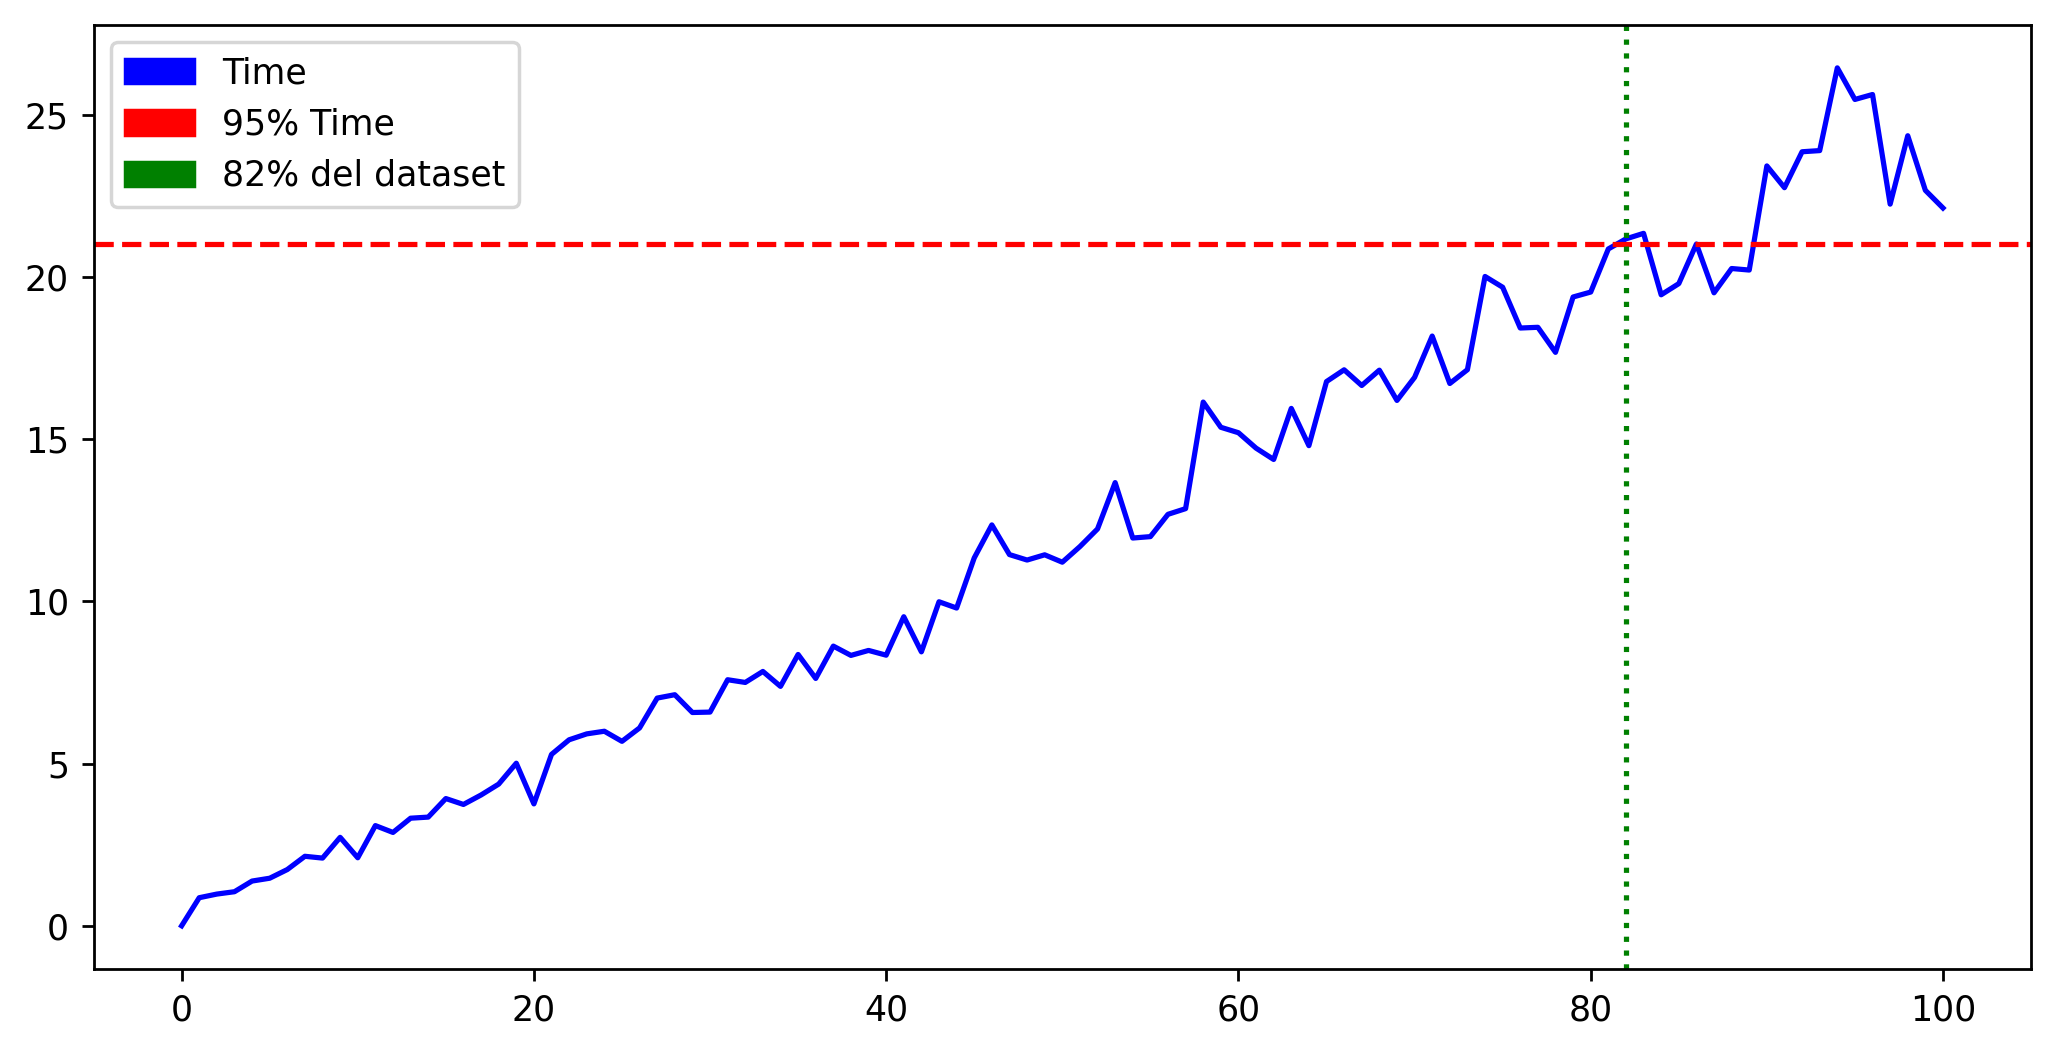

In [26]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 250



interesse="Time"
mappa= timeRes




for i in percentuali:
    if mappa[i] > mappa[100]*.95:
        break

grafico(mappa=mappa, label=interesse, xline=i, xlabel=str(i)+'% del dataset', 
            yline=mappa[100]*.95, ylabel="95% "+interesse)

plt.savefig("NN_"+interesse+".pdf", bbox_inches='tight')

In [19]:
import matplotlib.patches as mpatches

def grafico(mappa=list(), label="", color="blue", xline=None, xcolor='green', xlinestyle=":", xlabel="", 
            yline=None, ycolor='red', ylinestyle="--", ylabel=""):
    x = [0]
    y = [0]
    
    for i in percentuali:
        x.append(i)
        y.append(mappa[i])
    plt.plot(x,y, color=color)
    
    legenda = list()
    
    legenda.append(mpatches.Patch(color=color, label=label))
    
    if yline != None:
        plt.axhline(y=yline, color=ycolor, linestyle =ylinestyle)
        legenda.append(mpatches.Patch(color=ycolor, label=ylabel))
    
    if xline != None:
        plt.axvline(x=xline, color=xcolor, linestyle =xlinestyle)
        legenda.append(mpatches.Patch(color=xcolor, label=xlabel))
        
    
    plt.legend(handles=legenda)

In [75]:
y_test

track_id
62646     4
114596    2
148773    4
3902      6
63162     5
         ..
52324     5
134068    5
25603     9
32332     2
150018    2
Name: TRACK_genre_top_num, Length: 14783, dtype: int64